In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
from registration import loadSlice, commonSegment, computeCostBetweenAll2Dimages,costFromMatrix, global_optimization, commonProfil, sliceProfil, updateCostBetweenAllImageAndOne,cost_fct, normalization, loadimages 
from data_simulation import createMvt, SimulImageWth0Transform, ErrorInParametersEstimation, createVolumesFromAlist
from display import displayIntensityProfil, plotsegment, indexMse, indexGlobalMse, Histo
import warnings
from input_argparser import InputArgparser
from os import listdir
from os.path import isfile, join, splitext
import pickle
warnings.filterwarnings("ignore")

#from kim_cm import

In [2]:
dir_output='sub-0259_ses-0307'+'.pickle'
print(dir_output)
res=pickle.load(open(dir_output,'rb'))
listimages=res['listimages']
listmask=res['listmask']

listSlice=[]
for i in range(len(listimages)):
        im, inmask = loadimages(listimages[i], listmask[i])
        datamask = inmask.get_fdata().squeeze()
        mask = nib.Nifti1Image(datamask, inmask.affine)
        loadSlice(im, mask, listSlice, i)
        

sub-0259_ses-0307.pickle


In [3]:
class Viewer3D:
    """
    Viewer 3D is a class that alow to visualize the intersection between two orthogonal slices. You can select which image 
    you want to vizualise and which slice in each images. The intersection can be visualize with and without the mask
    The class take three diffents 3D images as parameters : it can be 'axial', 'sagital' and 'coronal' and their associated
    mask
    """
    def __init__(self,listSlice,data): 
        
        
        listSlice = normalization(listSlice)
        
        #attributes initialisation
        
        listtmp = listSlice.copy()
        self.listSlice = listtmp
        self.nbSlice=len(self.listSlice)
        
        self.images,mask = createVolumesFromAlist(self.listSlice.copy())
        self.imgsize=[]
        for i in range(len(self.images)):
            self.imgsize.append(len(self.images[i]))
        
        self.choice = 'mask'
        self.orientation1 = 0
        self.orientation2 = 1
        self.numImg1 = 0
        self.numImg2 = 0
        self.error = 'mse'
        
        self.ErrorEvolution =res['ErrorEvolution'] #= np.load(data + 'ErrorEvolution.npz')['arr_0'] #0
        self.DiceEvolution =res['DiceEvolution'] #= np.load(data + 'DiceEvolution.npz')['arr_0']
        
        self.nbit = len(self.ErrorEvolution)
        display(self.ErrorEvolution)
   
        self.EvolutionGridError = res['EvolutionGridError'] #np.load(data + 'EvolutionGridError.npz')['arr_0']
        
        self.EvolutionGridNbpoint = res['EvolutionGridNbpoint'] #np.load(data + 'EvolutionGridNbpoint.npz')['arr_0']

        self.EvolutionGridInter= res['EvolutionGridInter'] #np.load(data + 'EvolutionGridInter.npz')['arr_0']

        self.EvolutionGridUnion= res['EvolutionGridUnion'] #np.load(data + 'EvolutionGridUnion.npz')['arr_0']

        self.EvolutionParameters = res['EvolutionParameters'] #np.load(data + 'EvolutionParameters.npz')['arr_0']

        self.iImg1 = 0
        self.iImg2 = 0
        
        self.Nlast=self.EvolutionGridError[self.nbit-1,:,:]
        self.Dlast=self.EvolutionGridNbpoint[self.nbit-1,:,:]
        self.lastMse=self.Nlast/self.Dlast
        self.valMax=np.max(self.lastMse[np.where(~np.isnan(self.lastMse))])
        
        print("Cost Before Registration : ", self.ErrorEvolution[0])
        print("Cost After Registration : ", self.ErrorEvolution[self.nbit-1])
        
        #fig = plt.figure(figsize=(10, 5))
        #ax1=plt.subplot(1,2,1)
        plt.plot(self.ErrorEvolution)
        plt.title('Evolution of the global cost over %d iteration' %(self.nbit-1))
        
        #ax2=plt.subplot(1,2,2)
        #ax2.plot(self.DiceEvolution)
        #ax2.set_title('Evolution of the Dice over %d iteration' %(self.nbit-1))
        
        
        widgets.interact(self.ErrorDisplay,
            nit=widgets.IntSlider(
            value=0,
            min=0,
            max=self.nbit-1,
            description='Iteration',
            disabled=False,
            button_style='', 
            tooltip='Description',
            icon='check' 
        ))
                         
        widgets.interact(self.ErrorParametersDisplay,
            nit=widgets.IntSlider(
            value=0,
            min=0,
            max=self.nbit-1,
            description='Iteration',
            disabled=False,
            button_style='', 
            tooltip='Description',
            icon='check' 
        ))
        
        #select the two images you are interested in
        widgets.interact(
        self.chooseImage12,orientation1 = widgets.Dropdown(
        options=range(len(self.images)),
        value=0,
        description='Image 1:',
        disabled=False,
        ),
        orientation2  = widgets.Dropdown(
        options=range(len(self.images)),
        value=0,
        description='Image 2:',
        disabled=False,
        ))
 
        #choose the intersection with mask or without mask
        widgets.interact(self.choicePlotSeg,
        choice = widgets.Dropdown(
        options=['mask','no_mask'],
        value='mask',
        description='mask ?',
        disabled=False,
        ))
        
        
        widgets.interact(self.choice_error,
        error = widgets.Dropdown(
        options=['dice','mse'],
        value='mse',
        description='error ?',
        disabled=False,
        ))
        
        #display lines of intersection intersection on images
        widgets.interact(self.plotSeg,
        go=widgets.ToggleButton(
        value=False,
        description='Ok!',
        disabled=False,
        button_style='', 
        tooltip='Description',
        icon='check'
        ))
        

    """
    Method of the class Viewer3D : choose two images of interest
    """
    def chooseImage12(self,orientation1,orientation2):
        
        self.orientation1 = orientation1
        self.orientation2 = orientation2
        
        data_img1=[];data_img2=[]
        for i in range(len(self.images)):
            if self.orientation1==i: 
                data_img1=self.images[i]
            if self.orientation2==i:
                data_img2=self.images[i]
       
                
        nbImage1 = len(data_img1)
        nbImage2 = len(data_img2)
        ListImage1 = range(0,nbImage1)
        ListImage2 = range(0,nbImage2)
        
        widgets.interact(
        self.chooseSlice12,numImg1 = widgets.Dropdown(
        options=ListImage1,
        description='Slice in 1:',
        disabled=False,
        ),

        numImg2 = widgets.Dropdown(
        options=ListImage2,
        description='Slice in 2:',
        disabled=False,
        ))
    
    
    """
    Method of the class Viewer3D, choose 2 slices of interest
    """
    def chooseSlice12(self,numImg1,numImg2):
        
        self.iImg1 = numImg1
        self.iImg2 = numImg2
        
        for i in range(len(self.images)):
            if self.orientation1==i:
                n=i-1; sum=0;
                while n>=0:
                    sum=sum+self.imgsize[n]
                    n=n-1
                self.numImg1 = numImg1 + sum
            if self.orientation2==i:
                n=i-1; sum=0;
                while n>=0:
                    sum=sum+self.imgsize[n]
                    n=n-1
                self.numImg2 = numImg2 + sum
            
        
    """
    Method of the class Viewer3D, choose the segment of interest
    """
    def choicePlotSeg(self,choice):
            self.choice=choice
    
    """
    Method of the class Viewer3D, choose the type of error
    """
    def choice_error(self,error):
        self.error = error
    
    
    """
    Method of the class Viewer3D, display the evolution of the error in the choosen iteration
    """
    def ErrorDisplay(self,nit):
            
            fig = plt.figure(figsize=(8, 8))
            cx  = plt.subplot()
            N = self.EvolutionGridError[nit,:,:] 
            D = self.EvolutionGridNbpoint[nit,:,:]
            MSE = N/D
            im = cx.imshow(MSE,vmin=0,vmax=self.valMax)
            cbar = fig.colorbar(im,ax=cx)
            for i in range(1,len(self.images)):
                n=i-1; sum=0;
                while n>=0:
                    sum=sum+self.imgsize[n]
                    n=n-1
                line=sum
                cx.hlines(y=line,xmin=0,xmax=self.nbSlice-1,lw=2,color='r')
                cx.vlines(x=line,ymin=0,ymax=self.nbSlice-1,lw=2,color='r')

            #plt.show()
            
    """
    Method of the class Viwer3D, display the error in parameters estimation in case of a simulation
    """
    def ErrorParametersDisplay(self,nit):
        
        NBPOINT_GLOB, ERROR_GLOB = indexGlobalMse(self.Nlast,self.Dlast) 
        lastmse=NBPOINT_GLOB/ERROR_GLOB
        a=np.where(np.isnan(lastmse))
        lastmse[a]=10
        nbpoint, error=indexGlobalMse(self.EvolutionGridError[nit,:,:],self.EvolutionGridNbpoint[nit,:,:])
        cmse=error/nbpoint
        b=np.where(np.isnan(cmse))
        fig = plt.figure(figsize=(10, 10))
        im=plt.scatter(range(self.nbSlice),self.EvolutionParameters[self.nbit-1,:,1],marker='.',c=lastmse)
        ax1=plt.subplot(3,2,1)
        ax1.scatter(range(self.nbSlice),self.EvolutionParameters[nit,:,0],marker='.',c=cmse) #[nit,0,:]
        ax1.set_title("Angle along x")
        ax1.set_xlabel("Number of slice")
        cbar = fig.colorbar(im,ax=ax1)
        ax2=plt.subplot(3,2,2)
        ax2.scatter(range(self.nbSlice),self.EvolutionParameters[nit,:,1],marker='.',c=cmse) #[nit,1,:]
        ax2.set_title("Angle along y")
        ax2.set_xlabel("Number of slice")
        cbar=fig.colorbar(im,ax=ax2)
        ax3=plt.subplot(3,2,3)
        ax3.scatter(range(self.nbSlice),self.EvolutionParameters[nit,:,2],marker='.',c=cmse) #[nit,2,:]
        ax3.set_title("Angle along z")
        ax3.set_xlabel("Number of slice")
        cbar = fig.colorbar(im,ax=ax3)
        ax4=plt.subplot(3,2,4)
        ax4.scatter(range(self.nbSlice),self.EvolutionParameters[nit,:,3],marker='.',c=cmse) #[nit,3,:]
        ax4.set_title("Translation along x")
        ax4.set_xlabel("Number of slice")
        cbar = fig.colorbar(im,ax=ax4)
        ax5=plt.subplot(3,2,5)
        ax5.scatter(range(self.nbSlice),self.EvolutionParameters[nit,:,4],marker='.',c=cmse) #[nit,4,:]
        ax5.set_title("Translation along y")
        ax5.set_xlabel("Number of slice")
        cbar = fig.colorbar(im,ax=ax5)
        ax6=plt.subplot(3,2,6)
        ax6.scatter(range(self.nbSlice),self.EvolutionParameters[nit,:,5],marker='.',c=cmse) #[nit,5,:]
        ax6.set_title("Translation along z")
        ax6.set_xlabel("Number of slice")
        cbar=fig.colorbar(im,ax=ax6)
        plt.title('Visualisation of the parameters for each slice at iteration %d' %(nit))
        fig.tight_layout()
        
    """
    Method of the class Viewer3D, display the evolution of the intersection between two slices
    """       
    def DisplayProfil(self,nit):
            
            listIteration = self.listSlice.copy()

            parameters = self.EvolutionParameters[nit,:,:].copy()
         
            i_slice = 0
            for s in listIteration:
                x = parameters[i_slice,:]
                s.set_parameters(x)
                i_slice=i_slice+1
        
            slice_img1 = listIteration[self.numImg1]
            slice_img2 = listIteration[self.numImg2]
            
            image1=slice_img1.get_slice().get_fdata();image2=slice_img2.get_slice().get_fdata()
            M1=slice_img1.get_transfo();M2=slice_img2.get_transfo();res=min(slice_img1.get_slice().header.get_zooms())
            pointImg1,pointImg2,nbpoint,ok=commonSegment(image1,M1,image2,M2,res)
            nbpoint=np.int32(nbpoint[0,0]);ok=np.int32(ok[0,0])
            display(ok)
            if ok>0:
                val1,index1,nbpointSlice1=sliceProfil(slice_img1, pointImg1, nbpoint)
                val2,index2,nbpointSlice2=sliceProfil(slice_img2, pointImg2, nbpoint)
                commonVal1,commonVal2,index=commonProfil(val1, index1, val2, index2, nbpoint)
                displayIntensityProfil(commonVal1,index1,commonVal2,index2,index)

            
            #display the intersection segment on the image, with ot without the mask
            fig=plt.figure(figsize=(10, 10))
            ax1=plt.subplot(1,2,1)
            ax2=plt.subplot(1,2,2)
            
            if self.choice=='no_mask':
                title1 = 'Intersection segment for image %s without mask, slice %d' %(self.orientation1,self.numImg1)
                title2 = 'Intersection segment for image %s without mask, slice %d'%(self.orientation2,self.iImg2)
                plotsegment(slice_img1,pointImg1,ok,nbpoint,ax1,title1,mask=np.nan,index=np.nan,nbpointSlice=None)
                plotsegment(slice_img2,pointImg2,ok,nbpoint,ax2,title2,mask=np.nan,index=np.nan,nbpointSlice=None)
                fig.tight_layout()
                
            elif self.choice=='mask':
                title1 = 'Intersection segment for image %s with mask,slice %d' %(self.orientation1,self.iImg1)
                title2 = 'Intersection segment for image %s with mask,slice %d' %(self.orientation2,self.iImg2)
                plotsegment(slice_img1,pointImg1,ok,nbpoint,ax1,title1,mask=slice_img1.get_mask(),index=index,nbpointSlice=nbpointSlice1)
                plotsegment(slice_img2,pointImg2,ok,nbpoint,ax2,title2,mask=slice_img2.get_mask(),index=index,nbpointSlice=nbpointSlice2) 
                fig.tight_layout()
            
    """
    Method of the class Viewer3D that gives the error and the number of point for each slices
    """
    def DisplayAllErrors(self,nit):
            
            #compute the error : case error is mse
            if self.error=='mse':
                
                Num=self.EvolutionGridError[nit,:,:]
                Denum=self.EvolutionGridNbpoint[nit,:,:]
                LastNum=self.EvolutionGridError[self.nbit-1,:,:]
                LastDenum=self.EvolutionGridNbpoint[self.nbit-1,:,:]
                NumImg1Row=self.EvolutionGridError[nit,self.numImg1,:];NumImg1Col=self.EvolutionGridError[nit,:,self.numImg1]
                DenumImg1Row=self.EvolutionGridNbpoint[nit,self.numImg1,:];DenumImg1Col=self.EvolutionGridNbpoint[nit,:,self.numImg1]
                NumImg2Row=self.EvolutionGridError[nit,self.numImg2,:];NumImg2Col=self.EvolutionGridError[nit,:,self.numImg2]
                DenumImg2Row=self.EvolutionGridNbpoint[nit,self.numImg2,:];DenumImg2Col=self.EvolutionGridNbpoint[nit,:,self.numImg2]
                
            if self.error=='dice':
                
                Num=self.EvolutionGridInter[nit,:,:]
                Denum=self.EvolutionGridUnion[nit,:,:]
                NumImg1Row=self.EvolutionGridInter[nit,self.numImg1,:];NumImg1Col=self.EvolutionGridInter[nit,:,self.numImg1]
                DenumImg1Row=self.EvolutionGridUnion[nit,self.numImg1,:];DenumImg1Col=self.EvolutionGridUnion[nit,:,self.numImg1]
                NumImg2Row=self.EvolutionGridInter[nit,self.numImg2,:];NumImg2Col=self.EvolutionGridInter[nit,:,self.numImg2]
                DenumImg2Row=self.EvolutionGridUnion[nit,:,self.numImg2];DenumImg2Col=self.EvolutionGridUnion[nit,:,self.numImg2]
                
            indexError1, indexNbpoint1=indexMse(Num,Denum,self.numImg1) 
            indexError2, indexNbpoint2=indexMse(Num,Denum,self.numImg2)
                
            size_indexError1=indexError1.shape[0]
            size_indexError2=indexError2.shape[0]
            indexMse1=np.zeros(size_indexError1)
            indexMse2=np.zeros(size_indexError2)

            for i in range(size_indexError1):
                indexMse1[i]=indexError1[i]/indexNbpoint1[i]
            for i in range(size_indexError2):
                indexMse2[i]=indexError2[i]/indexNbpoint2[i]

            maxIndex=max(self.numImg1,self.numImg2)
            minIndex=min(self.numImg1,self.numImg2)
            error=self.EvolutionGridError[nit,maxIndex,minIndex]
            commonPoint=self.EvolutionGridNbpoint[nit,maxIndex,minIndex]
                

            MSEloc=error/commonPoint
                

            sumError1=sum(NumImg1Row)  + sum(NumImg1Col)
            sumNbpoint1=sum(DenumImg1Row) + sum(DenumImg1Col)
            MSEGlobImg1=sumError1/sumNbpoint1

            sumError2=sum(NumImg2Row)  + sum(NumImg2Col)
            sumNbpoint2=sum(DenumImg2Row) + sum(DenumImg2Col)
            MSEGlobImg2=sumError2/sumNbpoint2
                

            NBPOINT_GLOB, ERROR_GLOB = indexGlobalMse(Num,Denum)
            LAST_POINT, LAST_ERROR = indexGlobalMse(LastNum,LastDenum)
            
            size_error=NBPOINT_GLOB.shape[0]
            MSE_GLOB=np.zeros(size_error)
            LAST_MSE=np.zeros(size_error)

            for i in range(size_error):
                MSE_GLOB[i] = ERROR_GLOB[i]/NBPOINT_GLOB[i]
                LAST_MSE[i] = LAST_ERROR[i]/LAST_POINT[i]
            
            threshold=1.25*np.median(LAST_MSE[~np.isnan(LAST_MSE)])
            display(threshold)
            
            if  np.any(~np.isnan(indexMse1)):
                fig=plt.figure(figsize=(30, 8))
                ax1=plt.subplot(1,2,1)
                ax1.set_ylabel('MSE')
                ax1.scatter(range(self.nbSlice),indexMse1)
                ax1.hlines(y=threshold,xmin=0,xmax=self.nbSlice-1,lw=2,color='r')
                ax2 = ax1.twinx()
                ax2.scatter(range(self.nbSlice),indexNbpoint1,c='orange')
                ax2.set_ylabel('Nbpoint')
                ax1.set_title('MSE between slice %d in image %s and its orthogonal slices' %(self.iImg1,self.orientation1))
                ax1.set_xlabel('Slices')
                fig.tight_layout()
                indexHistoMse1=(indexMse1[np.where(~np.isnan(indexMse1))])
                ax3=plt.subplot(1,2,2)
                histoMse=ax3.hist(indexHistoMse1)
                ax3.set_title('Histogram of the MSE between slice %d in image %s and its orthogonal slices' %(self.iImg1,self.orientation1))
                fig.tight_layout()

            if  np.any(~np.isnan(indexMse2)):   
                fig=plt.figure(figsize=(30, 8))
                ax1=plt.subplot(1,2,1)
                ax1.set_ylabel('MSE')
                ax1.scatter(range(self.nbSlice),indexMse2)
                ax1.hlines(y=threshold,xmin=0,xmax=self.nbSlice-1,lw=2,color='r')
                ax2 = ax1.twinx()
                ax2.scatter(range(self.nbSlice),indexNbpoint2,c='orange')
                ax2.set_ylabel('Nbpoint')
                plt.title('MSE between slice %d in image %s and its orthogonal slices' %(self.iImg2,self.orientation2))
                fig.tight_layout()
                indexHistoMse2=(indexMse2[np.where(~np.isnan(indexMse2))])
                ax3=plt.subplot(1,2,2)
                histoMse2=ax3.hist(indexHistoMse2)
                ax3.set_title('Histogram of the MSE between slice %d in image %s and its orthogonal slices' %(self.iImg2,self.orientation2))
                fig.tight_layout()

            if  np.any(~np.isnan(MSE_GLOB)):
                fig=plt.figure(figsize=(30, 8))
                ax1=plt.subplot(1,2,1)
                ax1.set_ylabel('MSE')
                ax1.scatter(range(self.nbSlice),MSE_GLOB)
                ax1.hlines(y=threshold,xmin=0,xmax=self.nbSlice-1,lw=2,color='r')
                ax2 = ax1.twinx()
                ax2.scatter(range(self.nbSlice),NBPOINT_GLOB,c='orange')
                ax2.set_ylabel('Nbpoint')
                plt.title('Global MSE between each slices')
                fig.tight_layout()
                ax3=plt.subplot(1,2,2)
                HistoMSE_GLOB=(MSE_GLOB[np.where(~np.isnan(MSE_GLOB))])
                histoGlobal=ax3.hist(HistoMSE_GLOB)
                ax3.set_title('Histogram of the Global MSE')
                fig.tight_layout()
                    
                    
                    
    """
    Plot the segment of intersection in two images
    """
    def plotSeg(self,go):
        
        if go==True:

                widgets.interact(self.DisplayProfil,
                    nit=widgets.IntSlider(
                    value=0,
                    min=0,
                    max=self.nbit-1,
                    description='Iteration',
                    disabled=False,
                    button_style='',
                    tooltip='Description',
                    icon='check'
                )) 
               
                widgets.interact(self.DisplayAllErrors,
                    nit=widgets.IntSlider(
                    value=0,
                    min=0,
                    max=self.nbit-1,
                    description='Iteration',
                    disabled=False,
                    button_style='', 
                    tooltip='Description',
                    icon='check' 
                )) 
            


In [4]:
#Viewer3D(img1,mask1,img2,mask2,img3,mask3,data)

array([0.85383339, 0.57213692, 0.50885689, 0.48116399, 0.46606851,
       0.45611535, 0.48667139, 0.46826959, 0.46299472, 0.46086203,
       0.45818724])

Cost Before Registration :  0.8538333861524574
Cost After Registration :  0.45818724330070404


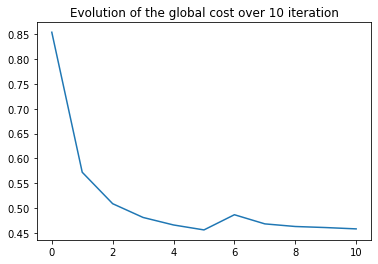

interactive(children=(IntSlider(value=0, description='Iteration', max=10), Output()), _dom_classes=('widget-in…

interactive(children=(IntSlider(value=0, description='Iteration', max=10), Output()), _dom_classes=('widget-in…

interactive(children=(Dropdown(description='Image 1:', options=(0, 1, 2), value=0), Dropdown(description='Imag…

interactive(children=(Dropdown(description='mask ?', options=('mask', 'no_mask'), value='mask'), Output()), _d…

interactive(children=(Dropdown(description='error ?', index=1, options=('dice', 'mse'), value='mse'), Output()…

interactive(children=(ToggleButton(value=False, description='Ok!', icon='check', tooltip='Description'), Outpu…

In [5]:
Viewer3D(listSlice,dir_output)

In [6]:
#https://github.com/mohakpatel/ImageSliceViewer3D/blob/master/ImageSliceViewer3D.ipynb 